**Computational Health Laboratory Project, A.Y. 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Andrea Zuppolini

# **CHL Project, Pathway Analysis**

## **Colab setup**
Takes care of the project setup on Colab.

In [4]:
if 'google.colab' in str(get_ipython()):
    import subprocess
    from google.colab import drive
    out_clone = subprocess.run(["git", "clone", "https://github.com/nikodallanoce/ComputationalHealthLaboratory"], text=True, capture_output=True)
    print("{0}{1}".format(out_clone.stdout, out_clone.stderr))
    %pip install -U PyYAML
    drive.mount("/content/drive/")
    %cp "/content/drive/Shareddrives/CHL/config.yml" "/content/ComputationalHealthLaboratory"
    %cd ComputationalHealthLaboratory

fatal: destination path 'ComputationalHealthLaboratory' already exists and is not an empty directory.

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/ComputationalHealthLaboratory


## **Obtain all the genes that interacts with the starting one**
Starting from a gene obtain its neighbours and the interactions between them.


In [5]:
import requests
import json
import pandas as pd
import numpy as np
from config import ACCESS_KEY, BASE_URL

In [6]:
gene_interactions = pd.read_csv("datasets/geneset.csv", sep=";")
gene_interactions["InteractorA"] = gene_interactions["InteractorA"].str.upper()
gene_interactions.drop_duplicates(inplace=True)
proteins_list = list(gene_interactions["InteractorA"])  # all the proteins that interact with our starting gene

In [7]:
gene_interactions

,InteractorA,InteractorB
0,YWHAG,SON
1,YWHAB,SON
3,SIRT7,SON
4,TCF3,SON
5,SF3B1,SON
...,...,...
149,NSP8,SON
150,NSP9,SON
151,ORF6,SON
152,ORF8,SON


## **Expand the network**
Build the protein-to-protein network using the interactions obtained from the previous step.

In [8]:
request_url = BASE_URL + "/interactions"
data = {}

step = 146
for i in range(0, len(proteins_list), step):
    end = i+step
    if end >= len(proteins_list):
        end = len(proteins_list)
    
    # List of genes to search for
    gene_list = proteins_list[i:end] # ["SRPK2"]

    params = {
        "accesskey": ACCESS_KEY,
        "format": "json",  # Return results in TAB2 format
        "geneList": "|".join(gene_list),  # Must be | separated
        "searchNames": "true",  # Search against official names
        "includeInteractors": "false",  # Set to true to get any interaction involving EITHER gene, set to false to get interactions between genes
        "includeInteractorInteractions": "false",  # Set to true to get interactions between the geneList’s first order interactors
        "includeEvidence": "false",  # If false "evidenceList" is evidence to exclude, if true "evidenceList" is evidence to show
        "selfInteractionsExcluded": "true", # If true no self-interactions will be included
    }

    r = requests.get(request_url, params=params)
    interactions = r.json()
    
    # Check if the interactions are more than the allowed number
    if len(interactions)==10000:
      assert False

    # Create a hash of results by interaction identifier
    for interaction_id, interaction in interactions.items():
        data[interaction_id] = interaction

In [9]:
# Load the data into a pandas dataframe
dataset = pd.DataFrame.from_dict(data, orient="index")

# Re-order the columns and select only the columns we want to see
columns = ["OFFICIAL_SYMBOL_A", "OFFICIAL_SYMBOL_B"]
dataset = dataset[columns]

# Rename the columns and make all the values uppercase
dataset = dataset.rename(columns={"OFFICIAL_SYMBOL_A": "InteractorA", "OFFICIAL_SYMBOL_B": "InteractorB"})
dataset["InteractorA"] = dataset["InteractorA"].str.upper()
dataset["InteractorB"] = dataset["InteractorB"].str.upper()

# Print the dataframe
dataset

,InteractorA,InteractorB
17282,SFPQ,NONO
22627,EZH2,EED
119679,SRPK2,U2AF2
120105,SRSF6,RNPS1
120300,U2AF2,PUF60
...,...,...
3324902,BRD4,HIST1H4A
3324964,BRD3,NFIA
3324983,NSP10,NSP16
3325359,SFPQ,NONO


Drop duplicated interactions, they're not interesting from out point of view.

In [10]:
# Look for duplicated interactions
duplicated_interactions = pd.DataFrame(np.sort(dataset[["InteractorA", "InteractorB"]].values, 1)).duplicated()
print("Duplicated interactions:\n{0}".format(duplicated_interactions.value_counts()))

# Delete such interactions from the dataset
dataset = dataset[~duplicated_interactions.values]

Duplicated interactions:
False    2636
True     1661
dtype: int64


Drop self-loops since they're useless for our analysis.

In [11]:
# Look for interactions where both proteins are the same
same_proteins_interactions = pd.DataFrame(dataset[["InteractorA", "InteractorB"]].nunique(axis=1) == 1)
print("Useless interactions:\n{0}".format(same_proteins_interactions.value_counts()))

# Delete such interactions from the dataset
dataset = dataset[~same_proteins_interactions.values]

Useless interactions:
False    2623
True       13
dtype: int64


Unify the interactions from the starting gene with the ones obtained by the requests to the BioGrid dataset.

In [12]:
dataset = dataset.append(gene_interactions)
dataset

,InteractorA,InteractorB
17282,SFPQ,NONO
22627,EZH2,EED
119679,SRPK2,U2AF2
120105,SRSF6,RNPS1
120300,U2AF2,PUF60
...,...,...
149,NSP8,SON
150,NSP9,SON
151,ORF6,SON
152,ORF8,SON


In [13]:
nodes = dataset["InteractorA"].append(dataset["InteractorB"]).unique()
# Basterebbe fare l'append su genes nel caso considerassimo solamente i nodi iniziali
print("Number of nodes: {0}".format(len(nodes)))

Number of nodes: 147


In [14]:
# Save interactions and nodes dataset to csv
dataset.to_csv("interactions.csv")
pd.DataFrame(nodes).to_csv("genes.csv")

## **Draw the network**
Visualize the interactions between the proteins.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
protein_graph=nx.Graph(name='Protein Interaction Graph')
interactions = np.array(dataset)
for interaction in interactions:
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    protein_graph.add_edges_from([(a,b)]) # add weighted edge to graph

In [ ]:
# function to rescale list of values to range [newmin,newmax]
def rescale(l,newmin,newmax):
    arr = list(l)
    return [(x-min(arr))/(max(arr)-min(arr))*(newmax-newmin)+newmin for x in arr]

# use the matplotlib plasma colormap
graph_colormap = cm.get_cmap('coolwarm', 12)

# node color varies with Degree
c = rescale([protein_graph.degree(v) for v in protein_graph], 0.0, 0.9) 
c = [graph_colormap(i) for i in c]

# node size varies with betweeness centrality - map to range [10,100] 
bc = nx.betweenness_centrality(protein_graph) # betweeness centrality
s =  rescale([v for v in bc.values()], 400, 500)

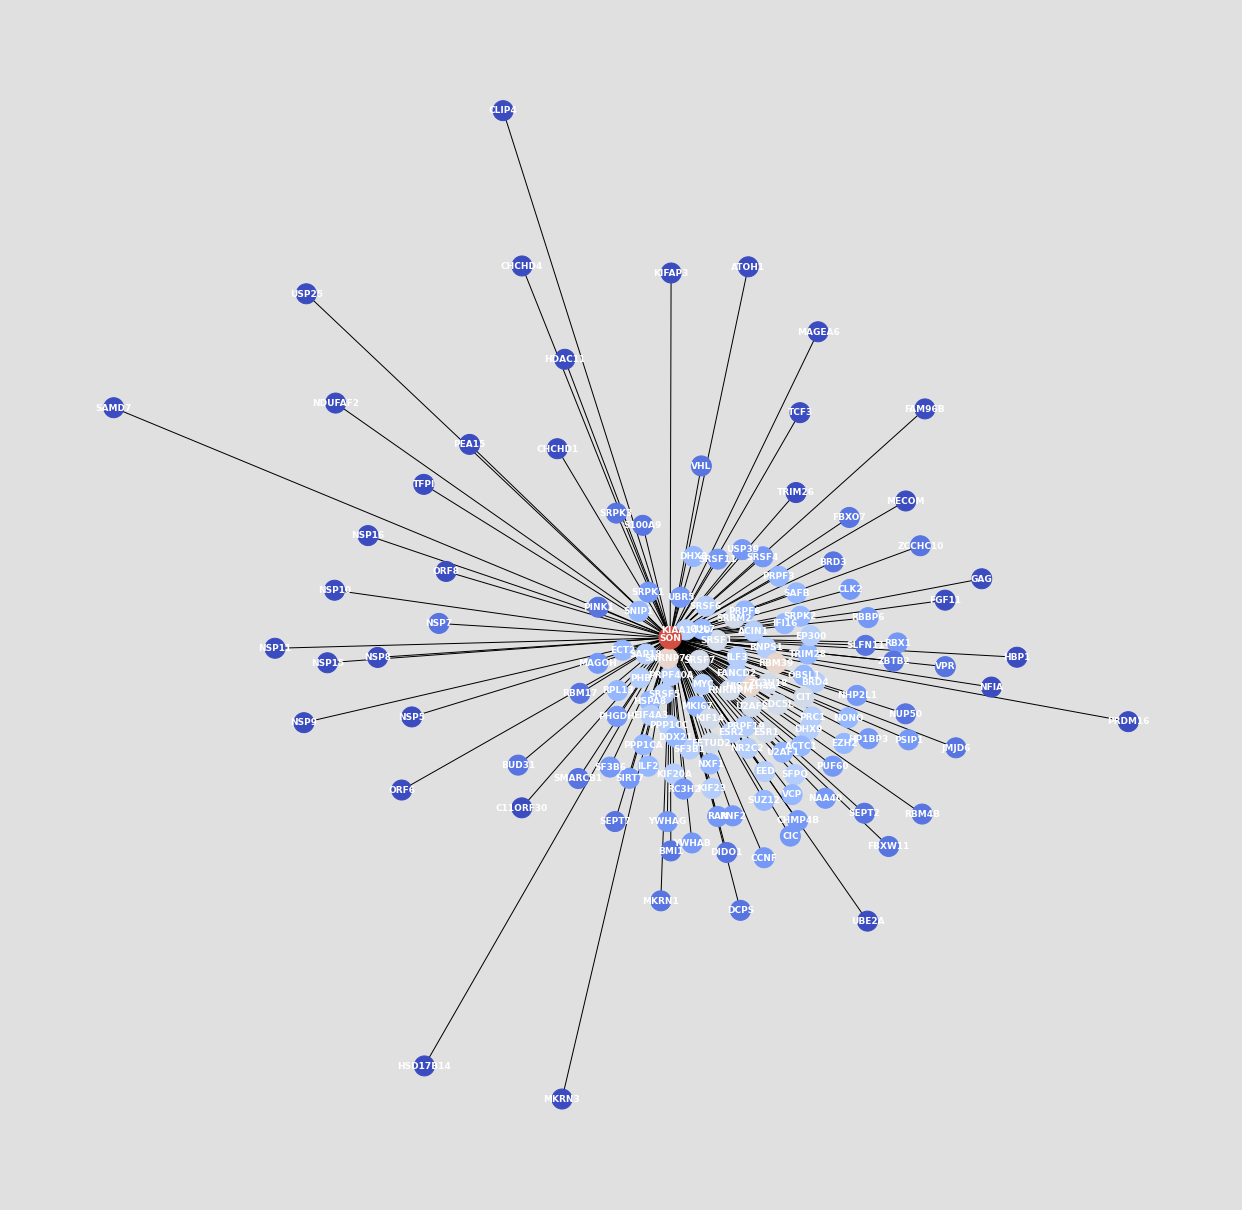

In [ ]:
pos = nx.spring_layout(protein_graph)
pos = nx.
plt.figure(figsize=(22, 22), facecolor=[0.7, 0.7, 0.7, 0.4])
nx.draw_networkx(protein_graph, pos=pos, with_labels=True, node_color=c, edgelist=np.array(gene_interactions), node_size=s, font_color='white',font_weight='bold', font_size='9')
plt.axis('off')
plt.show()

## **Pathway analysis**

In [ ]:
!pip install gseapy

In [28]:
import gseapy as gp
from gseapy.plot import barplot

In [ ]:
gp.get_library_name()

In [33]:
enr = gp.enrichr(gene_list=pd.DataFrame(nodes),
                 gene_sets=['KEGG_2021_Human'],
                 organism='Human', 
                 description='DEGs_up_1d',
                 outdir='test/enr_DEGs_Reactome_up',
                 cutoff=0.5 
                )

In [34]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Spliceosome,26/150,1.466088e-28,1.627357e-26,0,0,34.187817,2191.089821,DHX8;SF3B6;SRSF1;EIF4A3;U2AF1;PRPF19;USP39;EFT...
1,KEGG_2021_Human,mRNA surveillance pathway,8/98,6.334012e-07,3.515377e-05,0,0,12.638209,180.374569,PPP1CC;NXF1;EIF4A3;MAGOH;SAP18;ACIN1;RNPS1;PPP1CA
2,KEGG_2021_Human,RNA transport,8/186,7.135455e-05,2.215187e-03,0,0,6.361652,60.740098,NXF1;NUP50;MAGOH;EIF4A3;SAP18;ACIN1;RNPS1;RAN
3,KEGG_2021_Human,Ubiquitin mediated proteolysis,7/140,7.982655e-05,2.215187e-03,0,0,7.413534,69.951543,CUL7;FBXW11;UBR5;UBE2A;VHL;PRPF19;RBX1
4,KEGG_2021_Human,Oocyte meiosis,6/129,3.855125e-04,8.558376e-03,0,0,6.825809,53.657252,PPP1CC;FBXW11;YWHAB;YWHAG;RBX1;PPP1CA
...,...,...,...,...,...,...,...,...,...,...
106,KEGG_2021_Human,Parkinson disease,1/249,8.425155e-01,8.740114e-01,0,0,0.541455,0.092785,PINK1
107,KEGG_2021_Human,Pathways of neurodegeneration,2/475,8.673109e-01,8.843117e-01,0,0,0.565138,0.080452,PINK1;VCP
108,KEGG_2021_Human,Prion disease,1/273,8.683782e-01,8.843117e-01,0,0,0.493075,0.069587,HSPA8
109,KEGG_2021_Human,Huntington disease,1/306,8.971874e-01,9.053436e-01,0,0,0.438985,0.047626,EP300


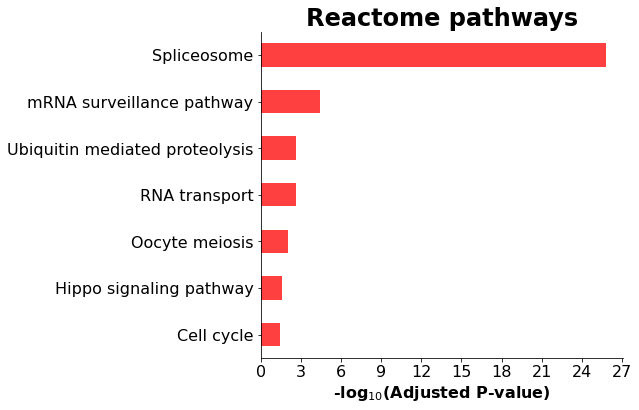

In [35]:
barplot(enr.res2d, title="Reactome pathways", color="r")